# Age Prediction Using ResNet50 and UTKFace Dataset

This project aims to predict the age of individuals from images using a pre-trained ResNet50 model. We will preprocess the dataset, train a model, and visualize the results using Grad-CAM.

## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
from PIL import Image
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.utils import to_categorical

import matplotlib.pyplot as plt
import cv2

2024-06-08 05:44:15.594983: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-08 05:44:15.595084: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-08 05:44:15.711939: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## 2. Load and Preprocess Data

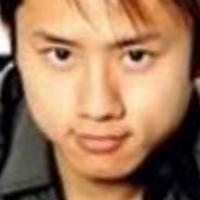

26


In [2]:
images = []
ages = []
for i in os.listdir('../input/utkface-new/UTKFace/')[0:23600]:
    split = i.split('_')
    ages.append(int(split[0]))
    images.append(Image.open('../input/utkface-new/UTKFace/' + i))

df = pd.DataFrame()
df['Images'], df['Ages'] = images, ages
df.head()

# Display the first image and age
display(df['Images'][0])
print(df['Ages'][0])

## 3. Visualize Age Distribution

/tmp/ipykernel_34/2520469046.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Ages'], kde=True, bins=80)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


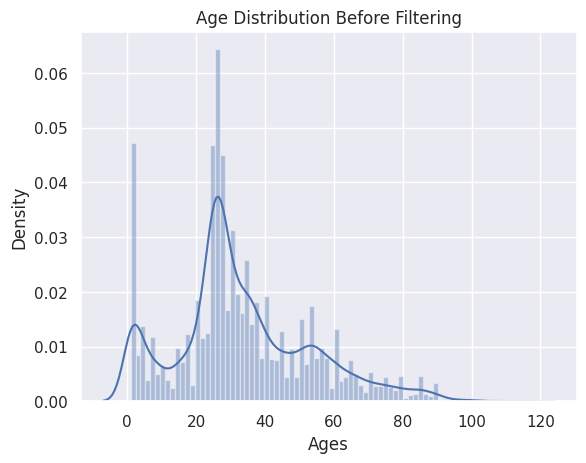

/tmp/ipykernel_34/2520469046.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Ages'], kde=True, bins=30)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


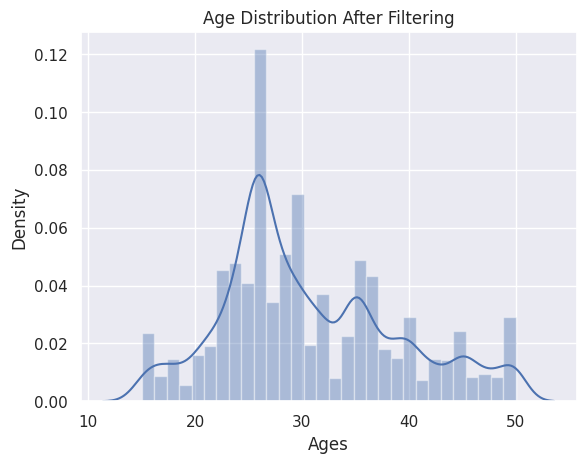

In [3]:
sns.set_theme()
sns.distplot(df['Ages'], kde=True, bins=80)
plt.title('Age Distribution Before Filtering')
plt.show()

# Filter the ages between 15 and 50
df = df[(df['Ages'] >= 15) & (df['Ages'] <= 50)]

sns.distplot(df['Ages'], kde=True, bins=30)
plt.title('Age Distribution After Filtering')
plt.show()

## 4. Resize Images and Convert to Arrays

In [9]:
# Resize images and convert to arrays
x = []

for img in df['Images']:
    resized_img = img.resize((128, 128), Image.Resampling.LANCZOS)  # Use LANCZOS instead of ANTIALIAS
    ar = np.asarray(resized_img)
    x.append(ar)

x = np.array(x)

In [10]:
x = np.array(x)

# Check the shape of the data
print(x.shape)

y_age = df['Ages']

(15382, 128, 128, 3)


## 5. Train-Test Split

In [11]:
x_train_age, x_test_age, y_train_age, y_test_age = train_test_split(x, y_age, test_size=0.2, stratify=y_age, random_state=42)
y_train_age

22539    47
2761     27
10334    42
11206    26
980      37
         ..
5709     29
821      50
5251     30
15502    26
7066     18
Name: Ages, Length: 12305, dtype: int64

## 6. Define and Compile the Model
Using the pre-trained ResNet50 model with custom layers for age prediction.

In [14]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import Sequential, regularizers, optimizers
from tensorflow.keras.layers import Flatten, Dense, Dropout

# Load the ResNet50 model, pre-trained on ImageNet, without the top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False

# Create a Sequential model and add the ResNet50 base model
agemodel = Sequential()
agemodel.add(base_model)

# Add custom layers for age prediction
agemodel.add(Flatten())
agemodel.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
agemodel.add(Dropout(0.5))  # Adding dropout layer to reduce overfitting
agemodel.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
agemodel.add(Dense(1, activation='relu'))

# Compile the model
agemodel.compile(loss='mae',
                 optimizer=optimizers.Adam(learning_rate=0.0001), 
                 metrics=['mae'])

# Print the model summary
agemodel.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ ?                      │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

## 7. Train the Model
Define callbacks for early stopping and learning rate reduction.

In [15]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Train the model
history = agemodel.fit(x_train_age, y_train_age,
                       epochs=50,  # Increase the number of epochs if needed
                       batch_size=32,  # Adjust batch size as per your data size
                       validation_data=(x_test_age, y_test_age),
                       callbacks=[early_stopping, reduce_lr])

# Evaluate the model on the test set
test_loss, test_mae = agemodel.evaluate(x_test_age, y_test_age)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

Epoch 1/50
  6/385 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - loss: 33.2046 - mae: 19.8576  

I0000 00:00:1717826254.115808     112 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


385/385 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 17.5792 - mae: 7.6677

W0000 00:00:1717826277.363254     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


385/385 ━━━━━━━━━━━━━━━━━━━━ 39s 61ms/step - loss: 17.5721 - mae: 7.6652 - val_loss: 11.6230 - val_mae: 5.6601 - learning_rate: 1.0000e-04
Epoch 2/50
385/385 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 11.4088 - mae: 5.9740 - val_loss: 14.9342 - val_mae: 10.7004 - learning_rate: 1.0000e-04
Epoch 3/50
385/385 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - loss: 9.5793 - mae: 5.5954 - val_loss: 11.4394 - val_mae: 8.0686 - learning_rate: 1.0000e-04
Epoch 4/50
385/385 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 8.5162 - mae: 5.2877 - val_loss: 11.4175 - val_mae: 8.5581 - learning_rate: 1.0000e-04
Epoch 5/50
385/385 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - loss: 7.8431 - mae: 5.0717 - val_loss: 10.9454 - val_mae: 8.4188 - learning_rate: 1.0000e-04
Epoch 6/50
385/385 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 7.5529 - mae: 5.0957 - val_loss: 12.4209 - val_mae: 10.1460 - learning_rate: 1.0000e-04
Epoch 7/50
385/385 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 7.0790 - mae: 4.8532 - val_loss: 13.6615 - val_mae:

## 8. Plot training & validation loss values

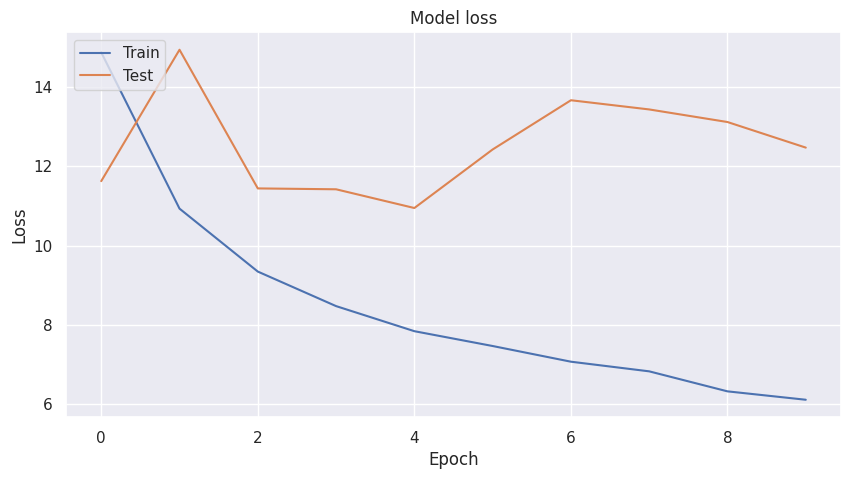

In [18]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## 9. Evaluate the model

In [20]:
loss, mae = agemodel.evaluate(x_test_age, y_test_age)
print(f"Mean Absolute Error on test data: {mae}")

97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 10.8186 - mae: 8.2921
Mean Absolute Error on test data: 8.418813705444336


In [24]:
# Predict ages
y_pred = agemodel.predict(x_test_age)

# Convert predictions to integer
y_pred_int = np.rint(y_pred).astype(int)
print(y_pred_int)

97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
[[22]
 [27]
 [21]
 ...
 [21]
 [25]
 [18]]


## 10.Confusion matrix

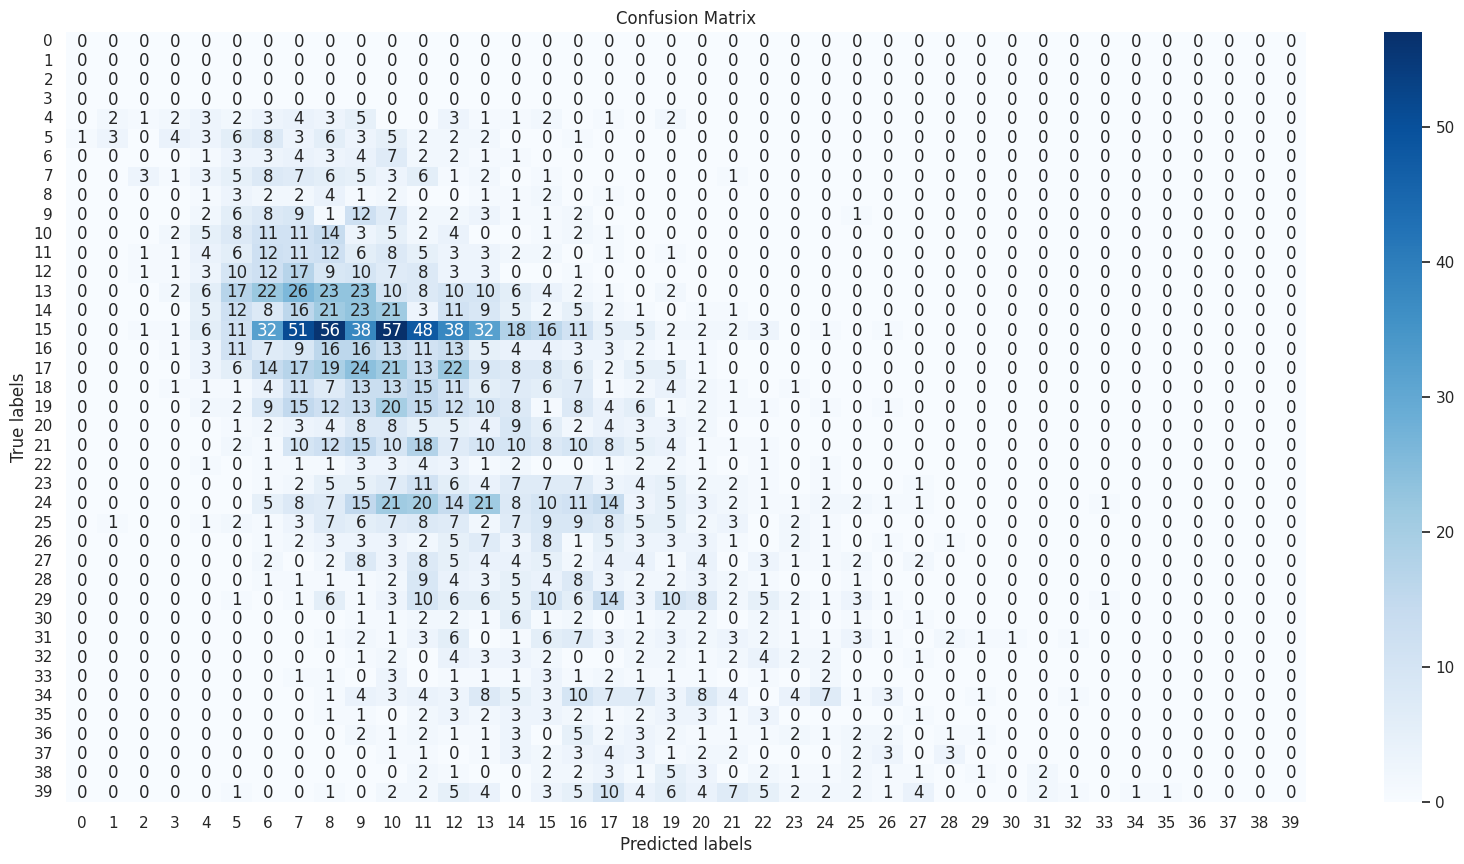

In [34]:
import seaborn as sns

# Assuming y_test_age and y_pred_int are defined

# Compute confusion matrix
cm = confusion_matrix(y_test_age, y_pred_int)

# Plot confusion matrix as heatmap
plt.figure(figsize=(20, 10))  # Adjust the figsize to your preference
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

## 8. Generate and Display Grad-CAM Heatmap

In [39]:
# Function to generate Grad-CAM heatmap
def get_gradcam_heatmap(model, img_array, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.input], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Function to display heatmap
def display_gradcam(img_path, heatmap, alpha=0.4):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))  # ResNet50 input size
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, 1 - alpha, heatmap, alpha, 0)
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.show()

### In the Grad-CAM heatmap:

#### Red and yellow areas: These areas represent the regions where the model is focusing more, indicating higher importance for prediction.
#### Blue and green areas: These areas represent regions with lower activation and less importance for prediction.

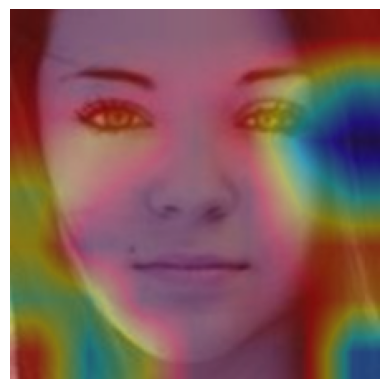

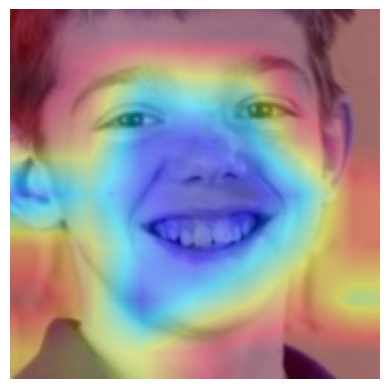

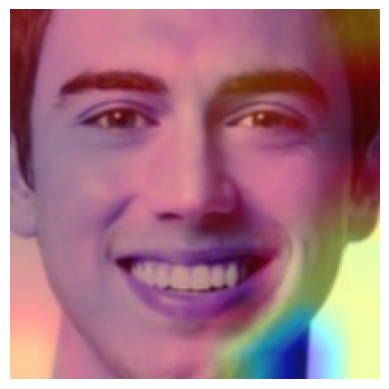

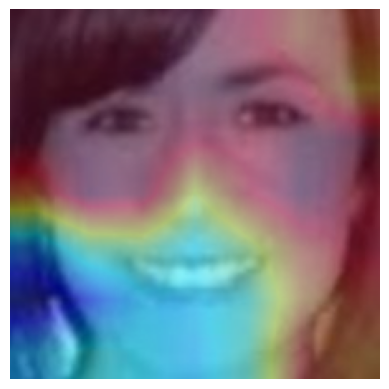

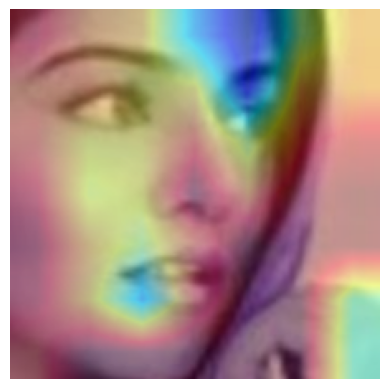

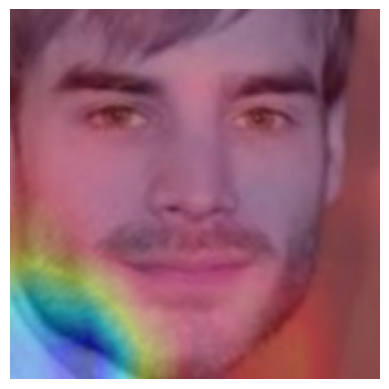

In [40]:
# List of image paths
image_paths = [
    '/kaggle/input/utkface-new/UTKFace/16_1_0_20170109212525685.jpg.chip.jpg',
    '/kaggle/input/utkface-new/UTKFace/10_0_0_20170110225421531.jpg.chip.jpg',
    '/kaggle/input/utkface-new/UTKFace/16_0_4_20170110231631592.jpg.chip.jpg',
    '/kaggle/input/utkface-new/UTKFace/20_1_0_20170103175416510.jpg.chip.jpg',
    '/kaggle/input/utkface-new/UTKFace/22_0_3_20170117143056386.jpg.chip.jpg',
    '/kaggle/input/utkface-new/UTKFace/24_0_0_20170104004125063.jpg.chip.jpg'
]

# Display Grad-CAM heatmaps for each image
for img_path in image_paths:
    img = image.load_img(img_path, target_size=(224, 224))  # ResNet50 input size
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    # Generate heatmap
    last_conv_layer_name = 'conv5_block3_out'  # last conv layer in ResNet50
    heatmap = get_gradcam_heatmap(base_model, img_array, last_conv_layer_name)

    # Display heatmap
    display_gradcam(img_path, heatmap)